In [12]:
# =========================
# Cell 1: Imports & global config
# =========================
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Pretty printing
pd.set_option('display.max_columns', 120)


In [13]:
# =========================
# Cell 2: Load the medical dataset (OpenML #37 - Pima Indians Diabetes)
# =========================
# Notes:
# - Target is typically named 'class' with values 'tested_positive' / 'tested_negative' or 0/1.
# - Features: pregnancies, glucose, blood pressure, skin thickness, insulin, BMI, pedigree, age.

dataset = openml.datasets.get_dataset(37)  # Pima Indians Diabetes Database
X, y, _, _ = dataset.get_data(dataset_format="dataframe",
                              target=dataset.default_target_attribute)

print(dataset)
print(f"Shape before encoding/cleaning: X={X.shape}, y={pd.Series(y).shape}")
print("Columns:", X.columns.tolist())
print("Target name:", dataset.default_target_attribute)
print("Target unique values (first 10):", pd.Series(y).astype(str).unique()[:10])


OpenML Dataset
Name.........: diabetes
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-06 23:22:13
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/37/diabetes.arff
OpenML URL...: https://www.openml.org/d/37
# of features: None
Shape before encoding/cleaning: X=(768, 8), y=(768,)
Columns: ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
Target name: class
Target unique values (first 10): ['tested_positive' 'tested_negative']


Columns where 0 likely means 'missing': ['plas', 'pres', 'skin', 'insu', 'mass']


,mean,std,min,max
preg,3.845052,3.369578,0.000000,17.000000
plas,120.894531,31.972618,0.000000,199.000000
pres,69.105469,19.355807,0.000000,122.000000
skin,20.536458,15.952218,0.000000,99.000000
insu,79.799479,115.244002,0.000000,846.000000
mass,31.992578,7.884160,0.000000,67.100000
pedi,0.471876,0.331329,0.078000,2.420000
age,33.240885,11.760232,21.000000,81.000000


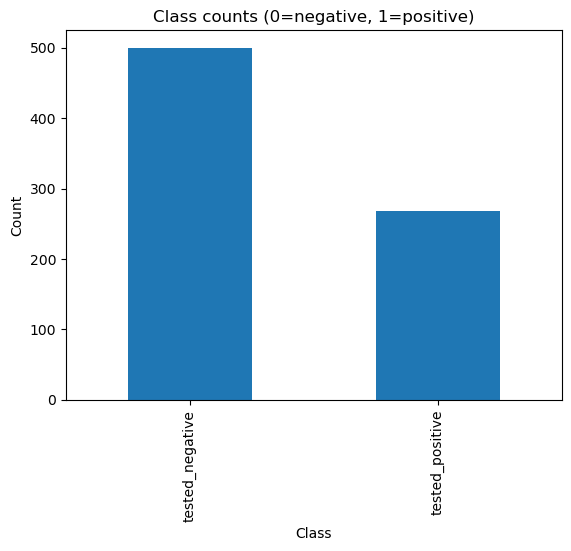

In [14]:
# =========================
# Cell 4: Basic EDA (summary & missing/invalid checks)
# =========================
# In Pima, some physiological features contain zeros, which are invalid (treated as 'missing'):
# Common columns with zeros-as-missing: glucose, blood pressure, skinfold, insulin, BMI.
zero_as_missing_candidates = [
    'plas', 'glucose', 'pres', 'blood_pressure', 'skin', 'skinthickness',
    'insu', 'insulin', 'mass', 'bmi'
]

present_zero_as_missing = [c for c in zero_as_missing_candidates if c in X.columns]
print("Columns where 0 likely means 'missing':", present_zero_as_missing)

# Show basic stats as a table
stats_table = X.describe().T[['mean','std','min','max']].head(10)

import pandas as pd
import matplotlib.pyplot as plt

# Display as pretty table
from IPython.display import display
display(stats_table.style.background_gradient(cmap="Blues").set_table_attributes("style='display:inline'"))

# Also show bar plot for class balance
y.value_counts().plot(kind='bar', title='Class counts (0=negative, 1=positive)')
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()



Columns where 0 likely means 'missing': ['plas', 'pres', 'skin', 'insu', 'mass']


,mean,std,min,max
preg,3.845052,3.369578,0.000,17.00
plas,120.894531,31.972618,0.000,199.00
pres,69.105469,19.355807,0.000,122.00
skin,20.536458,15.952218,0.000,99.00
insu,79.799479,115.244002,0.000,846.00
mass,31.992578,7.884160,0.000,67.10
pedi,0.471876,0.331329,0.078,2.42
age,33.240885,11.760232,21.000,81.00


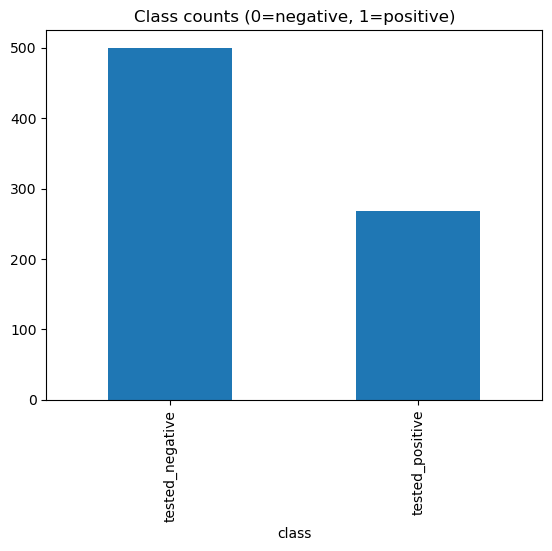

In [15]:
# =========================
# Cell 4: Basic EDA (summary & missing/invalid checks)
# =========================
# In Pima, some physiological features contain zeros, which are invalid (treated as 'missing'):
# Common columns with zeros-as-missing: glucose, blood pressure, skinfold, insulin, BMI.
zero_as_missing_candidates = [
    'plas', 'glucose', 'pres', 'blood_pressure', 'skin', 'skinthickness',
    'insu', 'insulin', 'mass', 'bmi'
]

present_zero_as_missing = [c for c in zero_as_missing_candidates if c in X.columns]
print("Columns where 0 likely means 'missing':", present_zero_as_missing)

# Show basic stats
display(X.describe().T[['mean','std','min','max']].head(10))

# Class balance bar
y.value_counts().plot(kind='bar', title='Class counts (0=negative, 1=positive)')
plt.show()


In [16]:
# =========================
# Cell 5: Replace zeros with NaN for specific columns, then impute
# =========================
X_clean = X.copy()

for col in present_zero_as_missing:
    X_clean.loc[X_clean[col] == 0, col] = np.nan

# Report missing rates after this replacement
missing_rates = X_clean.isna().mean().sort_values(ascending=False)
print("Missing rate (top 10):")
print(missing_rates.head(10))

# We will impute later inside the pipeline (median).


Missing rate (top 10):
insu    0.486979
skin    0.295573
pres    0.045573
mass    0.014323
plas    0.006510
preg    0.000000
pedi    0.000000
age     0.000000
dtype: float64


In [17]:
# =========================
# Cell 6: Train/test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [18]:
# =========================
# Cell 7: Define models
# - Interpretable by design: Logistic Regression (with scaling).
# - Black box: Gradient Boosting (no scaling needed).
# =========================

# Interpretable model pipeline:
# - Impute missing with median
# - Standardize features (LogReg benefits from scaling)
# - Logistic Regression with liblinear or lbfgs (small dataset)
logreg_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Black-box model (tree ensemble):
# - Impute missing with median (tree models don't need scaling)
gbm_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE
    ))
])

# Fit models
logreg_pipe.fit(X_train, y_train)
gbm_pipe.fit(X_train, y_train)


,steps,"[('imputer', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,loss,'log_loss'


Logistic Regression AUC: 0.813
Gradient Boosting AUC:  0.830


<Figure size 600x500 with 0 Axes>

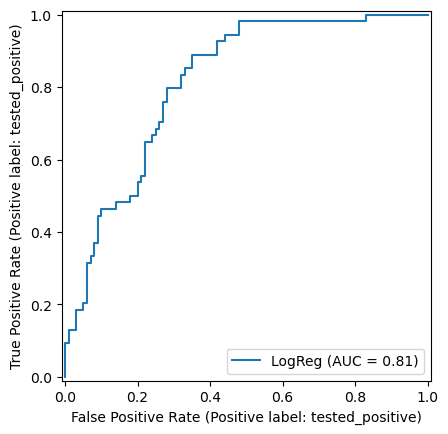

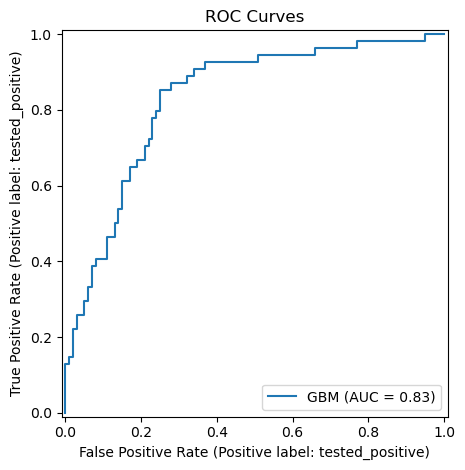

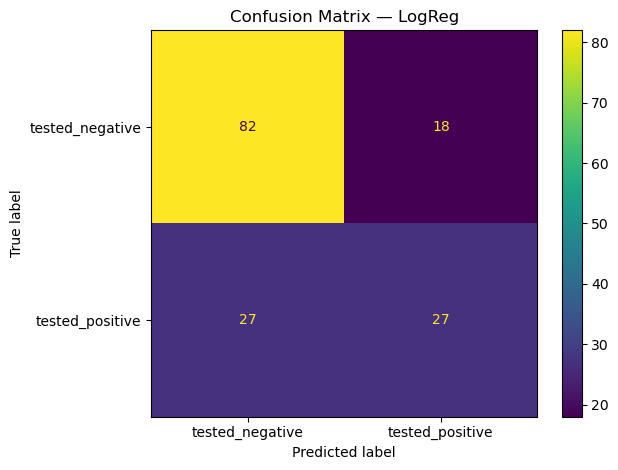

LogReg: Accuracy=0.708  Precision=0.600  Recall=0.500  F1=0.545


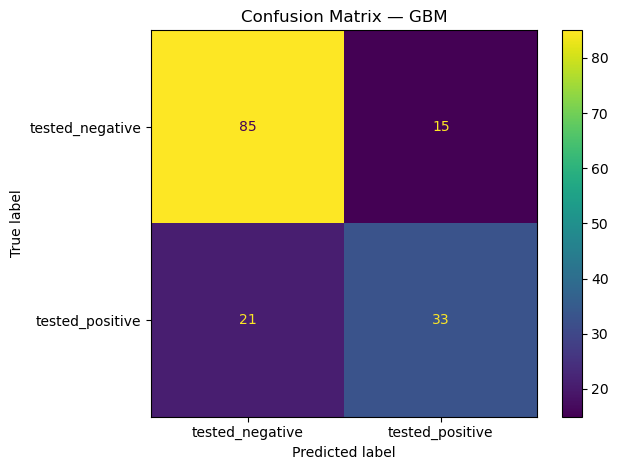

GBM: Accuracy=0.766  Precision=0.688  Recall=0.611  F1=0.647


In [22]:
# =========================
# Cell 8: Robust evaluation (handles string labels + missing pipelines)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
import os
os.makedirs("artifacts/outputs", exist_ok=True)

# --- 0) Helper: infer positive class label in y ---
def infer_pos_label(y):
    uniques = pd.unique(pd.Series(y))
    preferred = ['tested_positive','positive','pos','yes',1,'1',True]
    for c in preferred:
        if c in uniques:
            return c
    # fallback: choose the second of two classes if binary, else raise
    if len(uniques) == 2:
        return uniques[1]
    raise ValueError(f"Cannot infer positive label from classes: {uniques}")

pos_label = infer_pos_label(y_test)

# --- 1) Ensure pipelines exist and are fitted ---
if 'logreg_pipe' not in globals():
    logreg_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])
    logreg_pipe.fit(X_train, y_train)

if 'gbm_pipe' not in globals():
    gbm_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('clf', GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
        ))
    ])
    gbm_pipe.fit(X_train, y_train)

# --- 2) Get probabilities for the correct positive class column ---
def proba_for_pos(model, X, pos_label):
    classes = list(model.named_steps[list(model.named_steps.keys())[-1]].classes_)
    pos_idx = classes.index(pos_label)
    return model.predict_proba(X)[:, pos_idx]

y_proba_logreg = proba_for_pos(logreg_pipe, X_test, pos_label)
y_proba_gbm    = proba_for_pos(gbm_pipe,    X_test, pos_label)

# --- 3) AUC ---
auc_logreg = roc_auc_score(y_test, y_proba_logreg)
auc_gbm    = roc_auc_score(y_test, y_proba_gbm)
print(f"Logistic Regression AUC: {auc_logreg:.3f}")
print(f"Gradient Boosting AUC:  {auc_gbm:.3f}")

# --- 4) ROC curves (save image) ---
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_logreg, name="LogReg", pos_label=pos_label)
RocCurveDisplay.from_predictions(y_test, y_proba_gbm, name="GBM", pos_label=pos_label)
plt.title("ROC Curves")
plt.tight_layout()
plt.savefig("artifacts/outputs/roc_curves.png", dpi=300)
plt.show()

# --- 5) Confusion matrices + PRF (save each image) ---
for name, model in [("LogReg", logreg_pipe), ("GBM", gbm_pipe)]:
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    out_path = f"artifacts/outputs/confusion_{name.lower()}.png"
    plt.savefig(out_path, dpi=300)
    plt.show()

    acc = accuracy_score(y_test, y_pred)
    p, r, f, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0, pos_label=pos_label
    )
    print(f"{name}: Accuracy={acc:.3f}  Precision={p:.3f}  Recall={r:.3f}  F1={f:.3f}")



Top positive contributors (LogReg):


,feature,coef_logodds,odds_ratio
1,plas,1.182567,3.262739
5,mass,0.688652,1.991030
0,preg,0.377446,1.458554
6,pedi,0.233337,1.262807
7,age,0.147794,1.159274
3,skin,0.028321,1.028725
2,pres,-0.044111,0.956848
4,insu,-0.066119,0.936019


Top negative contributors (LogReg):


,feature,coef_logodds,odds_ratio
1,plas,1.182567,3.262739
5,mass,0.688652,1.991030
0,preg,0.377446,1.458554
6,pedi,0.233337,1.262807
7,age,0.147794,1.159274
3,skin,0.028321,1.028725
2,pres,-0.044111,0.956848
4,insu,-0.066119,0.936019


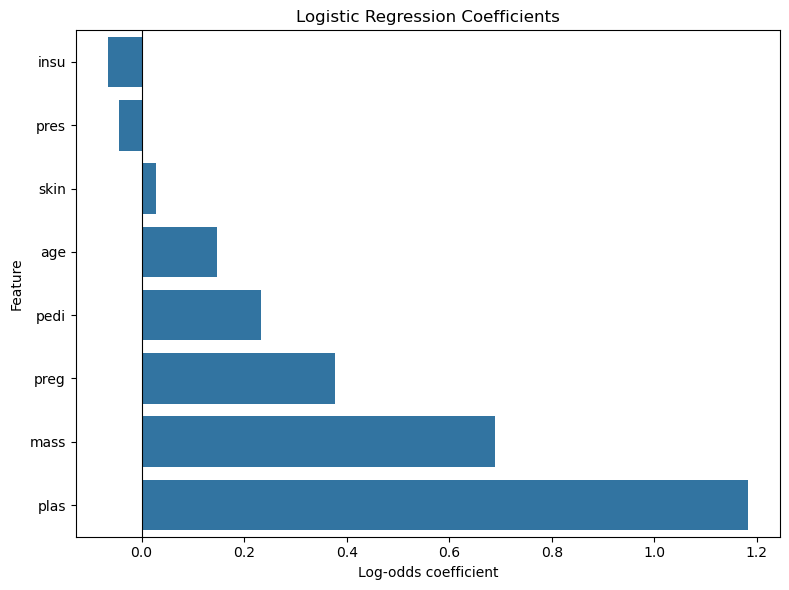

In [23]:
# =========================
# Cell 9: Logistic Regression coefficients (tables + image)
# =========================
import seaborn as sns

# Ensure logreg_pipe exists & fitted
if 'logreg_pipe' not in globals():
    logreg_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])
    logreg_pipe.fit(X_train, y_train)

imputer = logreg_pipe.named_steps['imputer']
scaler  = logreg_pipe.named_steps['scaler']
clf_lr  = logreg_pipe.named_steps['clf']

feature_names = X_train.columns.tolist()
coefs = clf_lr.coef_.ravel()
odds_ratios = np.exp(coefs)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef_logodds": coefs,
    "odds_ratio": odds_ratios
}).sort_values(by="coef_logodds", ascending=False)

print("Top positive contributors (LogReg):")
display(coef_df.head(10))
print("Top negative contributors (LogReg):")
display(coef_df.tail(10))

# Save the full table as CSV, not HTML
coef_df.to_csv("artifacts/outputs/logreg_coefficients_table.csv", index=False)

# Plot and save as PNG
plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df.sort_values("coef_logodds"),
    x="coef_logodds", y="feature"
)
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Log-odds coefficient")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.savefig("artifacts/outputs/logreg_coefficients.png", dpi=300)
plt.show()



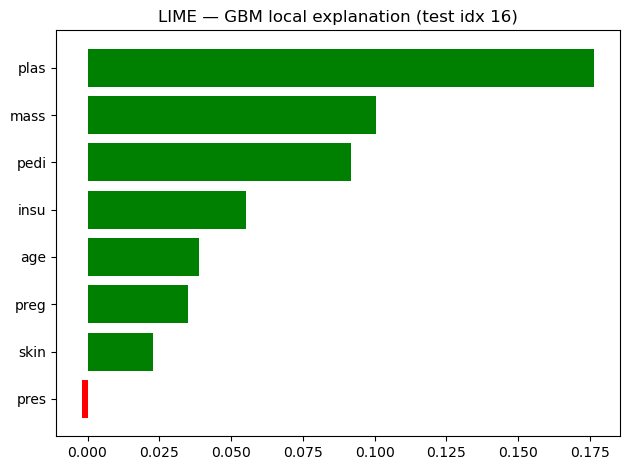

In [10]:
# =========================
# Cell 10: Local interpretation with LIME (on GBM)
# - Explains a single patient's prediction using a local surrogate model.
# - We wrap predict_proba to accept numpy and return proba with correct column names.
# =========================
import lime
import lime.lime_tabular

patient_idx = 16  # pick a test row to explain

# Keep using the pipeline for predictions (handles imputation internally)
def gbm_predict_proba_numpy(X_numpy):
    X_df = pd.DataFrame(X_numpy, columns=X_train.columns)
    return gbm_pipe.predict_proba(X_df)

# IMPORTANT: feed LIME clean data (no NaNs). Use the same imputer as the pipeline.
X_train_imp = pd.DataFrame(
    gbm_pipe.named_steps['imputer'].transform(X_train),
    columns=X_train.columns, index=X_train.index
)
X_test_imp = pd.DataFrame(
    gbm_pipe.named_steps['imputer'].transform(X_test),
    columns=X_test.columns, index=X_test.index
)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_imp.values,
    feature_names=X_train_imp.columns.tolist(),
    class_names=["negative", "positive"],
    mode="classification",
    discretize_continuous=False,   # <- key change
    random_state=RANDOM_STATE
)

lime_exp = explainer_lime.explain_instance(
    data_row=X_test_imp.iloc[patient_idx].values,
    predict_fn=gbm_predict_proba_numpy,
    num_features=10
)

fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME — GBM local explanation (test idx {patient_idx})")
plt.tight_layout()
plt.show()


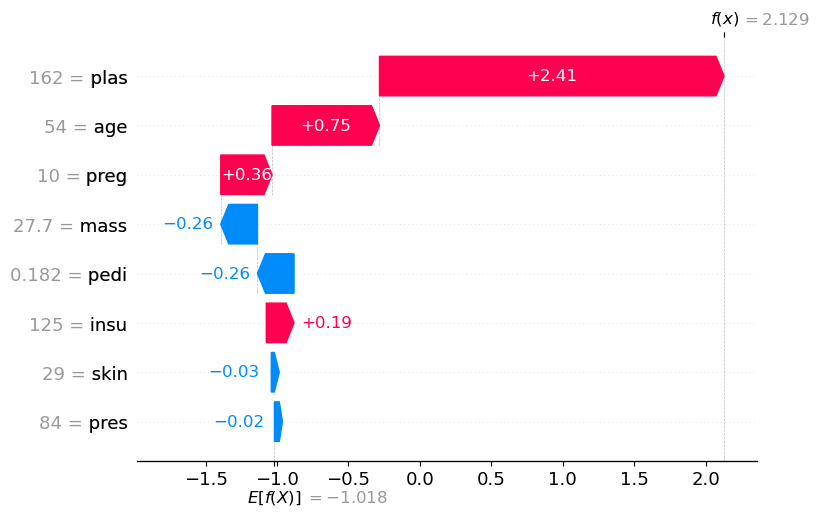

In [12]:
# =========================
# Cell 11: Local & Global interpretation with SHAP (on GBM)
# - TreeExplainer is ideal for tree ensembles.
# - Local: waterfall for one patient
# - Global: bar (mean |SHAP|) and beeswarm (distribution)
# =========================
import shap
shap.initjs()

# For scikit-learn GradientBoostingClassifier, TreeExplainer works well.
# SHAP expects the same column order as the training data.
explainer_shap = shap.TreeExplainer(gbm_pipe.named_steps['clf'])

# We must pass *imputed* test data to match what the model saw internally.
X_test_imputed = pd.DataFrame(
    logreg_pipe.named_steps['imputer'].transform(X_test),
    columns=X_test.columns, index=X_test.index
)
# Note: GBM does not need scaling, so imputed data is enough.

# Compute SHAP values (Explanation object)
shap_values = explainer_shap(X_test_imputed)

# Local waterfall for one patient
shap.plots.waterfall(shap_values[patient_idx], max_display=12)


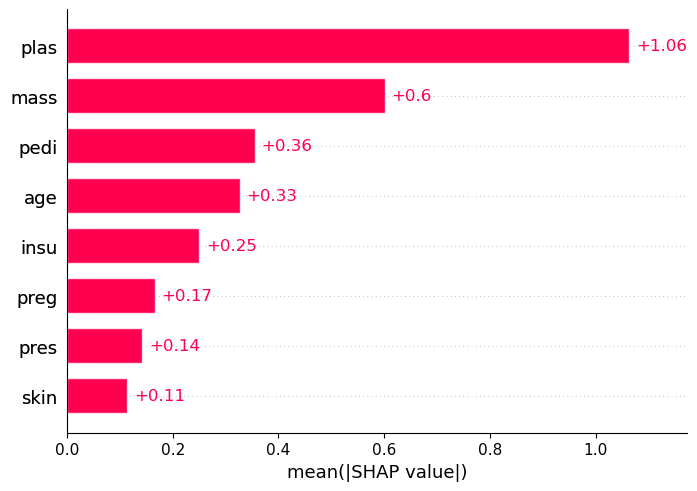

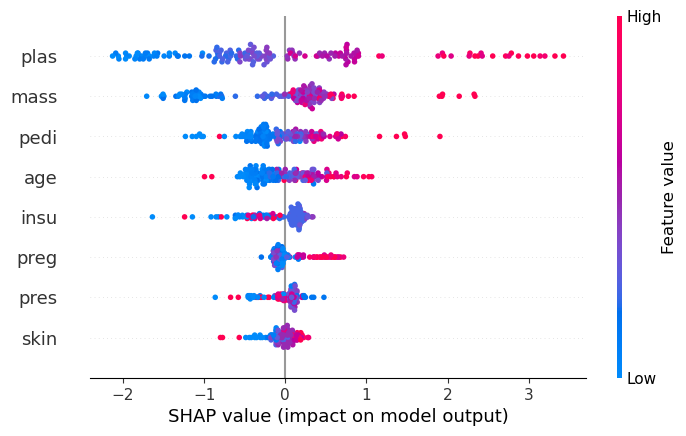

In [14]:
# =========================
# Cell 12: Global SHAP (bar + beeswarm)
# =========================
# Bar: mean absolute SHAP value per feature
shap.plots.bar(shap_values, max_display=15)

# Beeswarm: distribution of SHAP values across samples
shap.plots.beeswarm(shap_values, max_display=15)


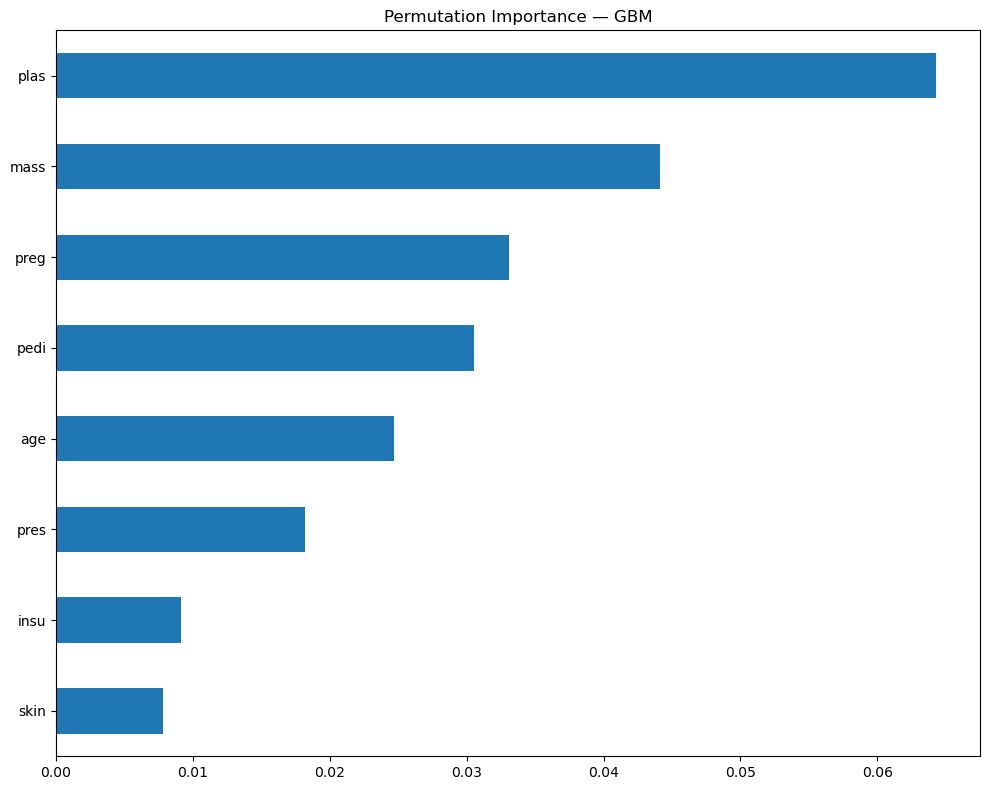

In [15]:
# =========================
# Cell 13: Global model-agnostic — Permutation Importance (on GBM)
# =========================
from sklearn.inspection import permutation_importance

# Use the *pipeline* directly for a faithful evaluation (imputes inside)
perm = permutation_importance(gbm_pipe, X_test, y_test, n_repeats=10,
                              random_state=RANDOM_STATE, n_jobs=None)

importances = pd.Series(perm.importances_mean, index=X_test.columns)
ax = importances.sort_values().plot(kind='barh', figsize=(10, 8),
                                    title='Permutation Importance — GBM')
plt.tight_layout()
plt.show()


In [18]:
# =========================
# Cell 14: (Optional) Save key figures for your slides/report
# =========================
# Example of saving a ROC figure; repeat as needed for LIME/SHAP plots by re-plotting then saving.

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_logreg, name="LogReg", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_gbm, name="GBM", ax=ax)
plt.title("ROC Curves")
fig.savefig("roc_curves_diabetes.png", dpi=200, bbox_inches="tight")
plt.close(fig)

print("Saved: roc_curves_diabetes.png")


Saved: roc_curves_diabetes.png


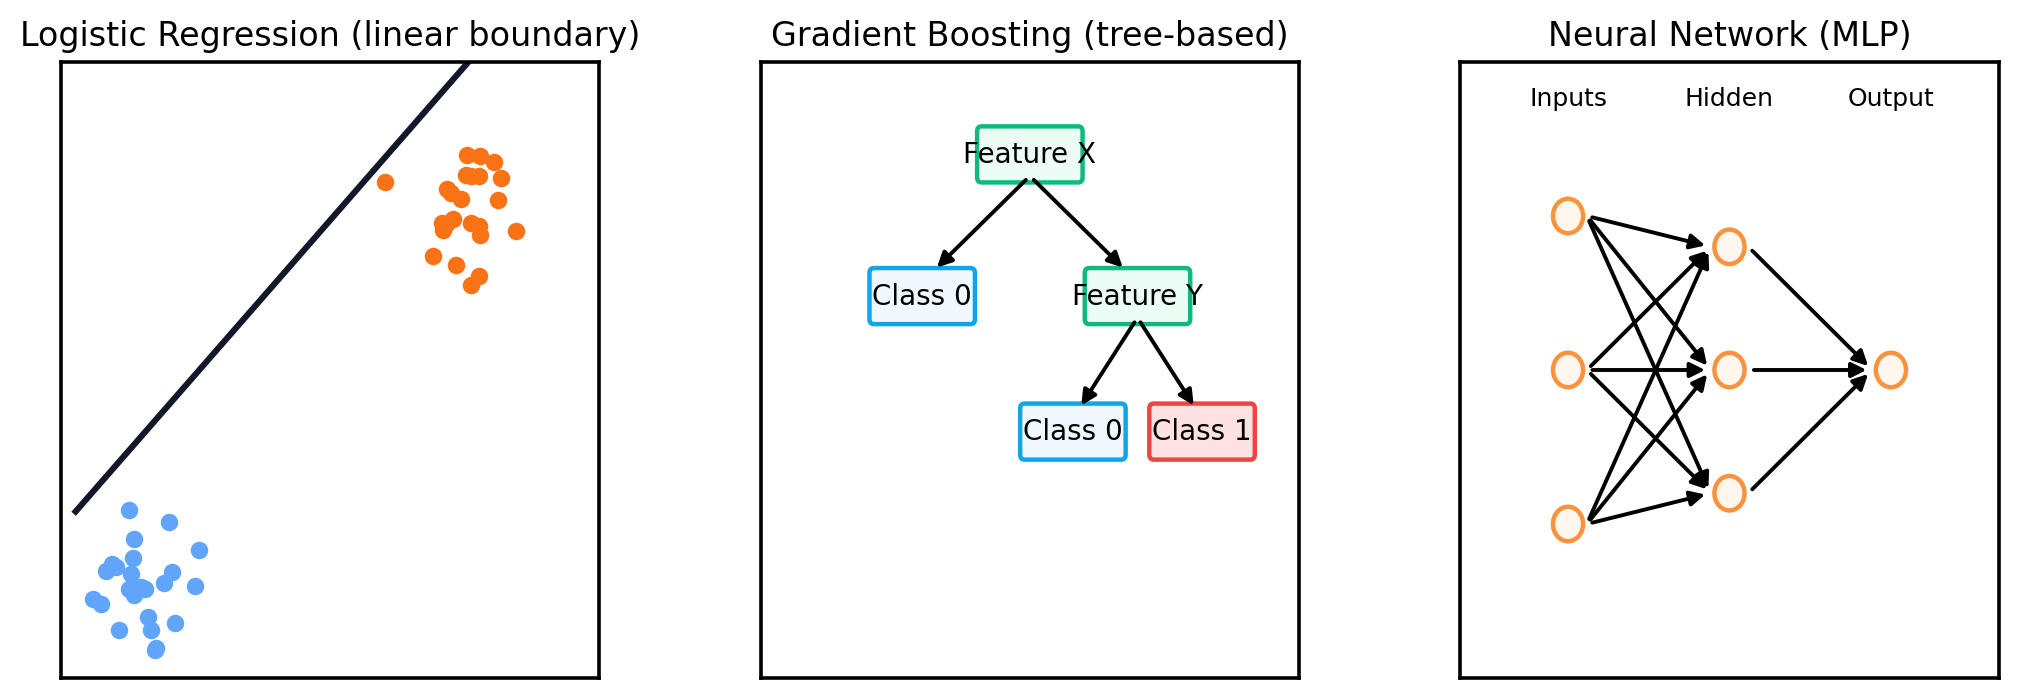

Saved:
  outputs/figures/model_types_comparison.png 
  outputs/figures/model_types_comparison.svg


In [10]:
# === Slide 12: Linear vs Tree vs Neural Net (fixed separability + tidy GBM boxes) ===
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle, ConnectionPatch

np.random.seed(42)

# ---------- Helpers ----------
def box(ax, xy, text, w=1.8, h=0.75, fc="#eef6ff", ec="#3b82f6"):
    x, y = xy
    p = FancyBboxPatch((x - w/2, y - h/2), w, h,
                       boxstyle="round,pad=0.08,rounding_size=0.08",
                       linewidth=1.6, facecolor=fc, edgecolor=ec)
    ax.add_patch(p)
    ax.text(x, y, text, ha="center", va="center", fontsize=10)
    return p

def node(ax, x, y, r=0.28, fc="#fff7ed", ec="#fb923c"):
    c = Circle((x, y), r, lw=1.6, facecolor=fc, edgecolor=ec)
    ax.add_patch(c)
    return (x, y)

def arrow(ax, A, B, color="black"):
    con = ConnectionPatch(A, B, "data", "data",
                          arrowstyle="-|>", mutation_scale=11,
                          lw=1.4, color=color, shrinkA=2, shrinkB=2)
    ax.add_artist(con)

# ---------- Figure ----------
fig = plt.figure(figsize=(12.5, 4), dpi=200)
gs = fig.add_gridspec(1, 3, wspace=0.30)

# ===== 1) Logistic Regression (NOW clearly separable) =====
ax1 = fig.add_subplot(gs[0, 0])

# Two tight blobs with a clear gap along y = x
x0 = np.random.normal(loc=[1.0, 1.0], scale=[0.22, 0.22], size=(24, 2))
x1 = np.random.normal(loc=[3.2, 3.2], scale=[0.22, 0.22], size=(24, 2))

ax1.scatter(x0[:,0], x0[:,1], s=28, label="Class 0", color="#60a5fa")
ax1.scatter(x1[:,0], x1[:,1], s=28, label="Class 1", color="#f97316")

# Clean linear separator with margin (line y = x + 0.9)
xx = np.linspace(0.5, 3.9, 200)
yy = xx + 0.9
ax1.plot(xx, yy, lw=2.2, color="#111827")

ax1.set_title("Logistic Regression (linear boundary)", fontsize=12)
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlim(0.4, 4.1); ax1.set_ylim(0.4, 4.1)
for s in ax1.spines.values(): s.set_linewidth(1.3)

# ===== 2) Gradient Boosting (tree sketch with tidy boxes) =====
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlim(0, 10); ax2.set_ylim(0, 10)
ax2.set_xticks([]); ax2.set_yticks([])
ax2.set_title("Gradient Boosting (tree-based)", fontsize=12)

root  = box(ax2, (5.0, 8.5), "Feature X", fc="#ecfdf5", ec="#10b981")
left  = box(ax2, (3.0, 6.2), "Class 0",   fc="#f0f9ff", ec="#0ea5e9")
right = box(ax2, (7.0, 6.2), "Feature Y", fc="#ecfdf5", ec="#10b981")
leaf1 = box(ax2, (5.8, 4.0), "Class 0",   fc="#f0f9ff", ec="#0ea5e9")
leaf2 = box(ax2, (8.2, 4.0), "Class 1",   fc="#fee2e2", ec="#ef4444")

arrow(ax2, (5.0, 8.15), (3.2, 6.6))
arrow(ax2, (5.0, 8.15), (6.8, 6.6))
arrow(ax2, (7.0, 5.85), (5.9, 4.35))
arrow(ax2, (7.0, 5.85), (8.1, 4.35))
for s in ax2.spines.values(): s.set_linewidth(1.3)

# ===== 3) Neural Network (MLP) =====
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_xlim(0, 10); ax3.set_ylim(0, 10)
ax3.set_xticks([]); ax3.set_yticks([])
ax3.set_title("Neural Network (MLP)", fontsize=12)
ax3.text(2, 9.3, "Inputs", ha="center", fontsize=9)
ax3.text(5, 9.3, "Hidden", ha="center", fontsize=9)
ax3.text(8, 9.3, "Output", ha="center", fontsize=9)

xs = [2, 5, 8]
yin  = [2.5, 5.0, 7.5]
yhid = [3.0, 5.0, 7.0]
yout = [5.0]

inputs  = [node(ax3, xs[0], y) for y in yin]
hidden  = [node(ax3, xs[1], y) for y in yhid]
outputs = [node(ax3, xs[2], y) for y in yout]

for x1,y1 in inputs:
    for x2,y2 in hidden:
        arrow(ax3, (x1+0.35, y1), (x2-0.35, y2))
for x1,y1 in hidden:
    for x2,y2 in outputs:
        arrow(ax3, (x1+0.35, y1), (x2-0.35, y2))
for s in ax3.spines.values(): s.set_linewidth(1.3)

# ---------- Save ----------
os.makedirs("outputs/figures", exist_ok=True)
png_path = "outputs/figures/model_types_comparison.png"
svg_path = "outputs/figures/model_types_comparison.svg"
plt.savefig(png_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(svg_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print("Saved:\n ", png_path, "\n ", svg_path)

